# Contents

01. Importing libraries
02. Importing data
03. Subsetting, wrangling, and cleaning time series data
04. Time series analysis: decomposition
05. Testing for stationarity
06. Stationarizing the Freddie Mac 30-Year Fixed Rate Mortgage Average Data

### 01. Importing libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

# Disable deprecation warnings
warnings.filterwarnings("ignore")

# Create styling option for plots
plt.style.use('fivethirtyeight')

### 02. Importing data

In [2]:
# Configure API key 
quandl.ApiConfig.api_key = 'rJxRj1qJ8ivoGxDwzVyL'

In [3]:
# Import the Freddie Mac (FMAC) "30-yr Fixed Rate Mortgage Average in the United States" variable
data = quandl.get('FMAC/30US')

In [4]:
# Check first five rows of data frame
data.head(5)

,Value
Date,
1971-04-02,7.33
1971-04-09,7.31
1971-04-16,7.31
1971-04-23,7.31
1971-04-30,7.29


In [5]:
# Check data frame shape
data.shape

(2627, 1)

In [6]:
# Check data columns
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

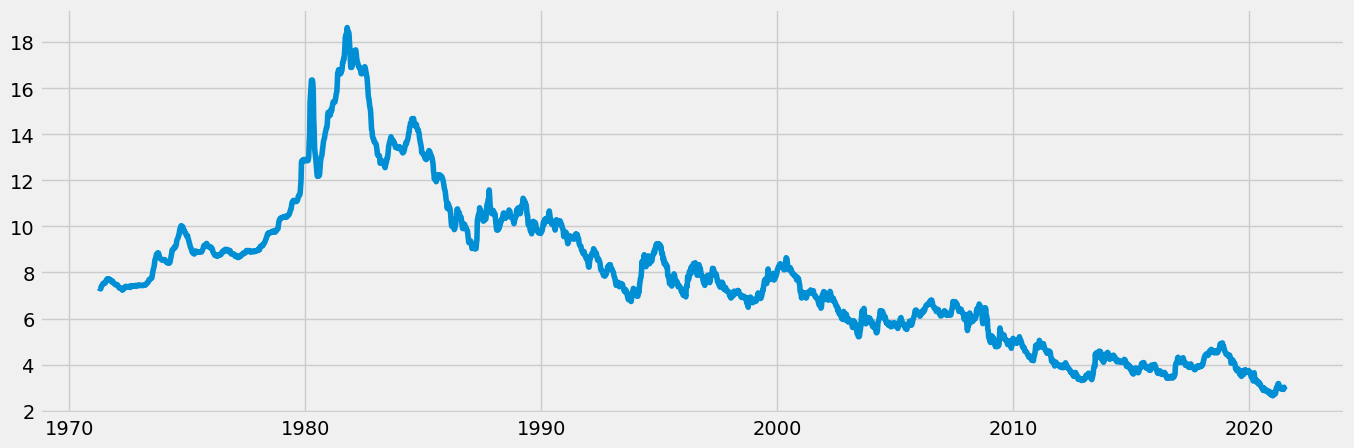

In [8]:
# Set the quality of the visualization
plt.figure(figsize=(15,5), dpi=100)

# Plot the data using matplotlib
plt.plot(data)

### 03. Subsetting, wrangling, and cleaning the time series data

In [9]:
# Reset the index to use the "Date" column as a filter
data_2 = data.reset_index()

In [10]:
# Check beginning of data_2
data_2.head()

,Date,Value
0,1971-04-02,7.33
1,1971-04-09,7.31
2,1971-04-16,7.31
3,1971-04-23,7.31
4,1971-04-30,7.29


In [11]:
# Create a subset
data_sub = data_2.loc[(data_2['Date'] >= '1990-01-01') & (data_2['Date'] < '2020-01-01')]

#### Q3. Explain what logic you were following when selecting your data points. I chose these data points because I wanted to view how the average 30-year fixed mortgage rate has behave over the past 30 years.

In [12]:
# Check shape of data subset
data_sub.shape

(1567, 2)

In [13]:
# Check beginning of data subset
data_sub.head()

,Date,Value
979,1990-01-05,9.83
980,1990-01-12,9.80
981,1990-01-19,9.90
982,1990-01-26,10.05
983,1990-02-02,10.17


In [14]:
# Set the "Date" column as the index
from datetime import datetime

# Create a datetime column from "Date"
data_sub['datetime'] = pd.to_datetime(data_sub['Date']) 

# Set the datetime as the index of the dataframe.
data_sub = data_sub.set_index('datetime') 

# Drop the "Date" column.
data_sub.drop(['Date'], axis=1, inplace=True) 

# Recheck the beginning of data subset
data_sub.head()

,Value
datetime,
1990-01-05,9.83
1990-01-12,9.80
1990-01-19,9.90
1990-01-26,10.05
1990-02-02,10.17


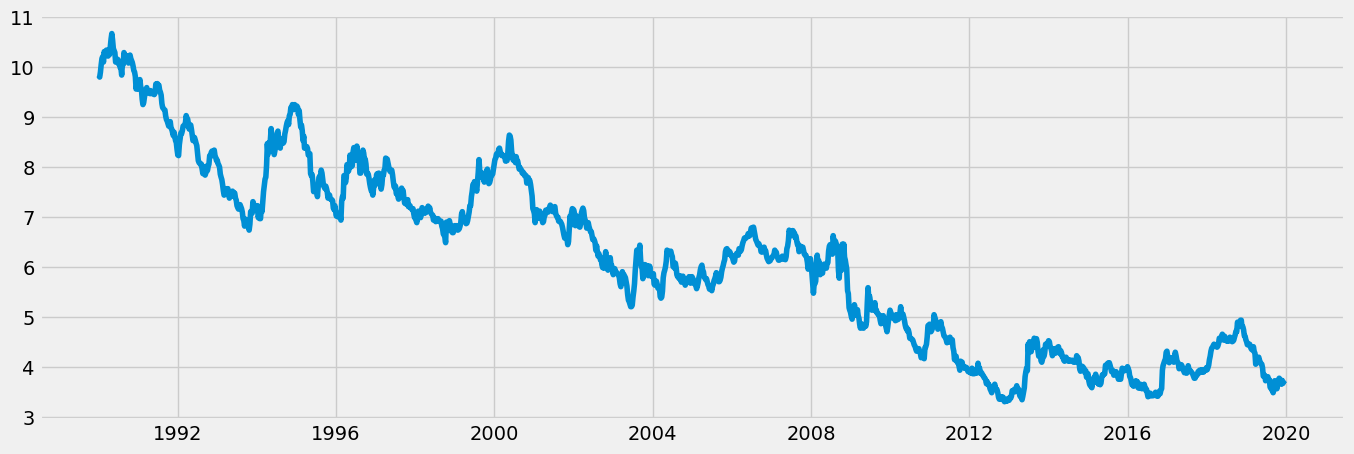

In [15]:
# Plot the data subset
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# Check for missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [17]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

# I verified from the original data set that these are not true duplicates. The average for some weeks were the same.

994

### 04. Time series analysis: decomposition

In [18]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='multiplicative', freq=52, extrapolate_trend = 52)

In [19]:
# Define a fixed size for all special charts
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 8

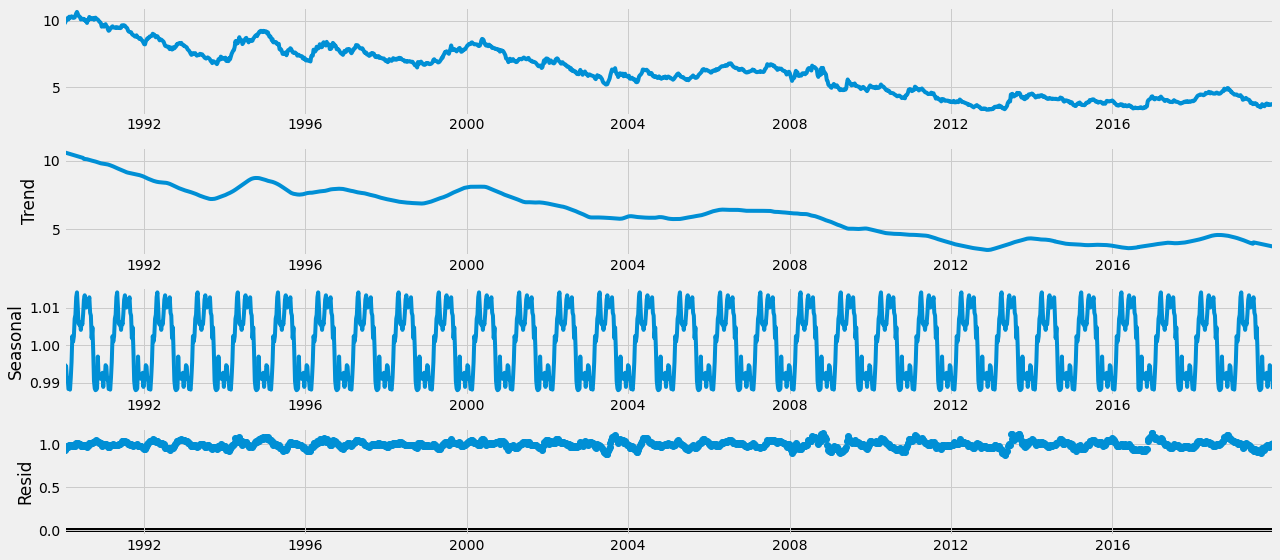

In [20]:
# Plot the separate components
decomposition.plot()
plt.show()

#### Q5. Analyze the results from the plot. The first component of the plot represents the original data. The second component is the underlying trend which gradually drops in a somewhat linear fashion from 1990 to 2020. The third component of the chart is the seasonality which shows the seasonal fluctuations at regular intervals. The fourth and last component is the noise. As can be seen from the chart, there isn't much noise present in the data.

### 05. Testing for stationarity

In [21]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define the function
def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   -1.914468
p-value                           0.325286
Number of Lags Used               8.000000
Number of Observations Used    1558.000000
Critical Value (1%)              -3.434554
Critical Value (5%)              -2.863397
Critical Value (10%)             -2.567759
dtype: float64


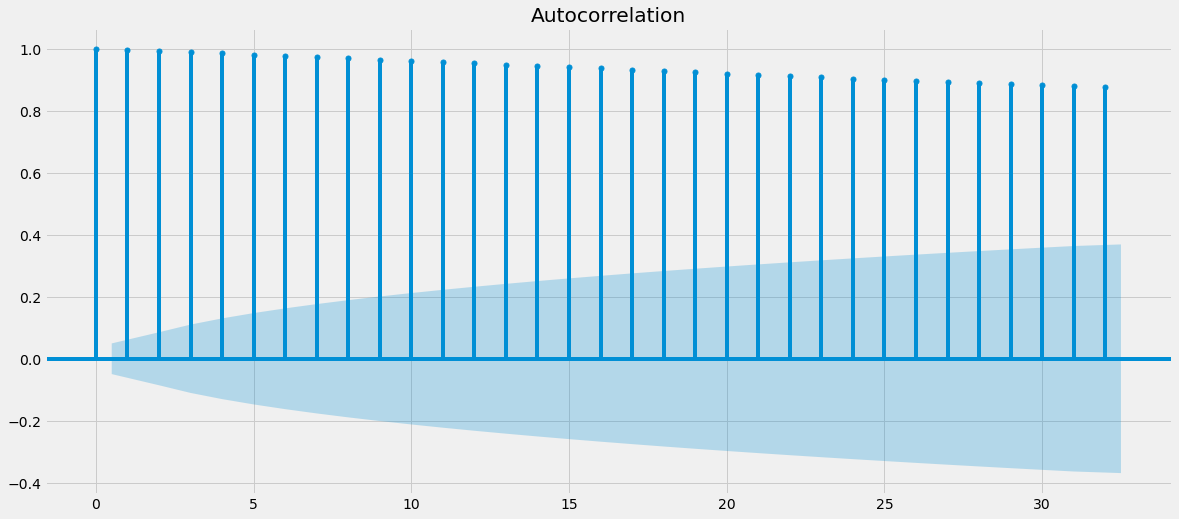

In [22]:
# Check out a plot of autocorrelations

# Import the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

#### Q6. Interpret the results and reference your null hypothesis. From the Dickey-Fuller Stationarity test, the test statistic is larger than all critical values which means that the null hypothesis can't be rejected. There is a unit root in the data and the data is non-stationary; therefore, forecasting of the data cannot be completed. The autocorrelation chart shows that there is a lot of autocorrelated data (many lags above the blue edge of the confidence interval correlated with each other) making the data non-stationary. This further supports the results of the Dickey-Fuller Stationarity test. 

### 06. Stationarizing the Freddie Mac 30-Year Fixed Rate Mortgage Average Data

In [23]:
# Make the observation t-1
data_diff = data_sub - data_sub.shift(1)

In [24]:
# Remove missing values
data_diff.dropna(inplace = True)

In [25]:
# Check beginning of the data_diff
data_diff.head()

,Value
datetime,
1990-01-12,-0.03
1990-01-19,0.10
1990-01-26,0.15
1990-02-02,0.12
1990-02-09,0.04


In [26]:
# Check data_diff columns
data_diff.columns

Index(['Value'], dtype='object')

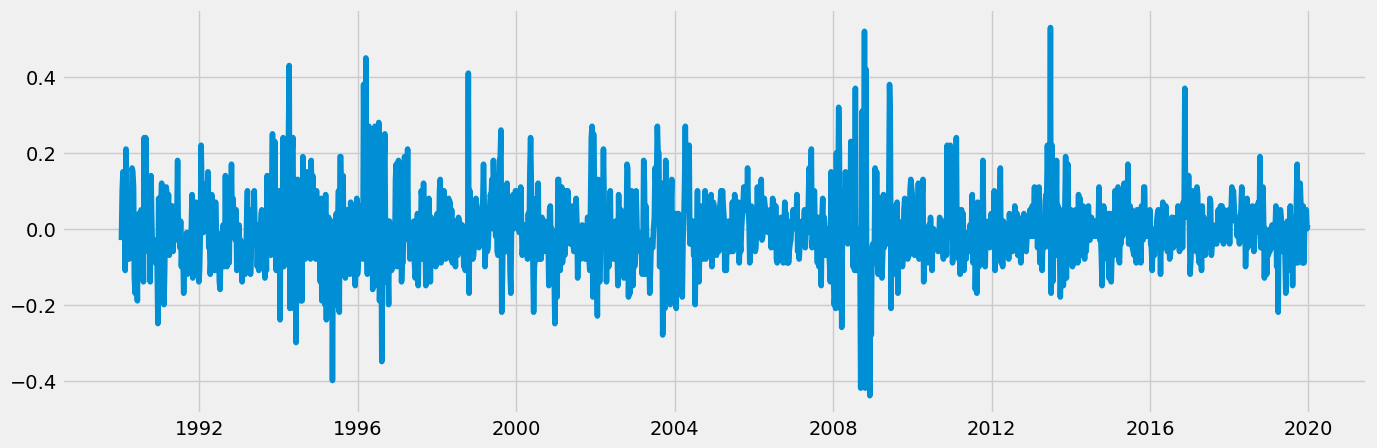

In [27]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
# Run Dickey-Fuller test on data_diff
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.317616e+01
p-value                        1.222120e-24
Number of Lags Used            7.000000e+00
Number of Observations Used    1.558000e+03
Critical Value (1%)           -3.434554e+00
Critical Value (5%)           -2.863397e+00
Critical Value (10%)          -2.567759e+00
dtype: float64


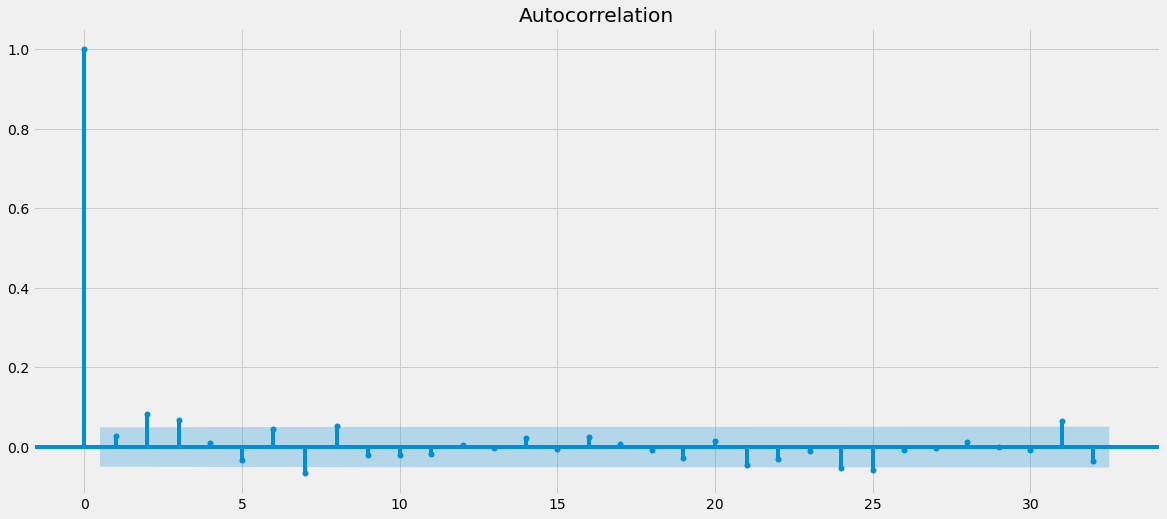

In [29]:
# Recheck autocorrelations
plot_acf(data_diff)
plt.show()

#### Q6. After stationarizing the data, the test statistic is now smaller than the all critical values meaning that the null hypothesis can now be rejected. There is no unit root, the data is stationary, and forecasting can be completed. Furthermore, there are a substantially fewer number of lags above the blue confidence interval indicating the data is stationary.